In [1]:
import kagglehub
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Download dataset
path = kagglehub.dataset_download("ayush1220/cifar10")
print("Path to dataset files:", path)

100%|██████████| 139M/139M [00:07<00:00, 19.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ayush1220/cifar10/versions/2


In [3]:
print("Contents:", os.listdir(path))

Contents: ['cifar10']


In [4]:
subdirs = os.listdir(path)
for sub in subdirs:
    print(sub, "=>", os.listdir(os.path.join(path, sub)))

cifar10 => ['test', 'train']


In [5]:
# Define directories
base_dir = os.path.join(path, 'cifar10')
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

In [6]:
# Parameters
img_height, img_width = 32, 32
batch_size = 64
epochs = 30

In [7]:
# Data Augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    shear_range=0.1,
    fill_mode='nearest'
)

In [8]:
# No augmentation for testing (only rescale)
test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 50000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


In [10]:
# CNN Model with dropout
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, verbose=1)

In [12]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=epochs,
    callbacks=[early_stop, lr_reduce]
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


782/782 ━━━━━━━━━━━━━━━━━━━━ 60s 68ms/step - accuracy: 0.2308 - loss: 2.0361 - val_accuracy: 0.4470 - val_loss: 1.5230 - learning_rate: 0.0010
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 48s 61ms/step - accuracy: 0.4153 - loss: 1.6119 - val_accuracy: 0.5396 - val_loss: 1.2944 - learning_rate: 0.0010
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 48s 61ms/step - accuracy: 0.4656 - loss: 1.4900 - val_accuracy: 0.5573 - val_loss: 1.2417 - learning_rate: 0.0010
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 48s 62ms/step - accuracy: 0.5054 - loss: 1.3902 - val_accuracy: 0.6170 - val_loss: 1.0946 - learning_rate: 0.0010
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 48s 61ms/step - accuracy: 0.5279 - loss: 1.3358 - val_accuracy: 0.6306 - val_loss: 1.0432 - learning_rate: 0.0010
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 48s 62ms/step - accuracy: 0.5494 - loss: 1.2828 - val_accuracy: 0.6222 - val_loss: 1.0445 - learning_rate: 0.0010
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5588 - loss: 1.2540


In [13]:
# Evaluate
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy:.2f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.7097 - loss: 0.8255
Test Accuracy: 0.72


In [14]:
# Predict on test set
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step


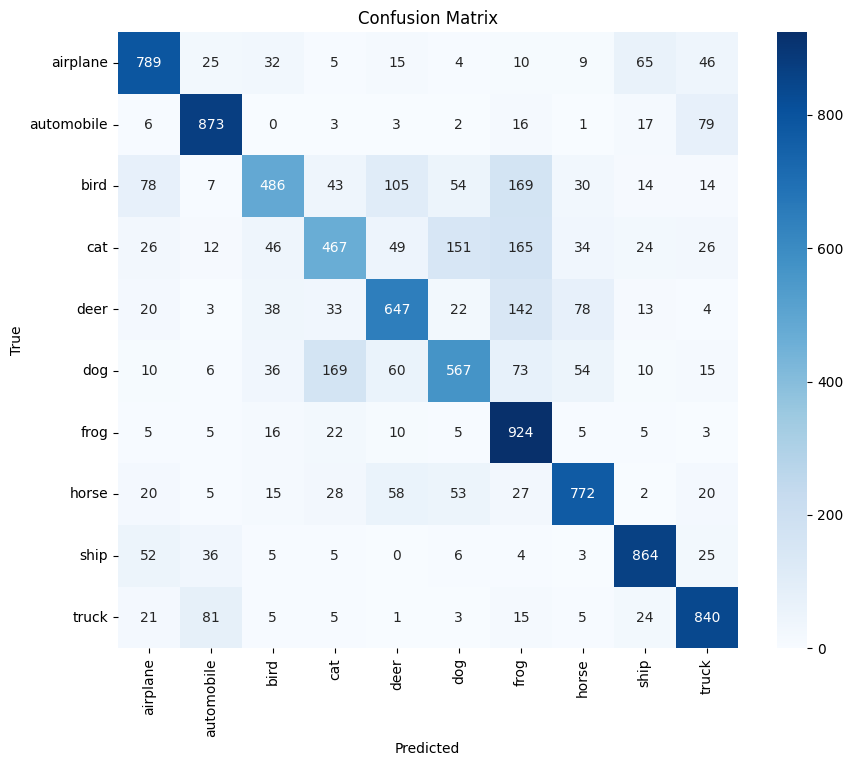

In [15]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [16]:
# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

Classification Report:

              precision    recall  f1-score   support

    airplane       0.77      0.79      0.78      1000
  automobile       0.83      0.87      0.85      1000
        bird       0.72      0.49      0.58      1000
         cat       0.60      0.47      0.52      1000
        deer       0.68      0.65      0.66      1000
         dog       0.65      0.57      0.61      1000
        frog       0.60      0.92      0.73      1000
       horse       0.78      0.77      0.78      1000
        ship       0.83      0.86      0.85      1000
       truck       0.78      0.84      0.81      1000

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000

